In [1]:
import numpy as np
import operator   # for sorting operation
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

% matplotlib inline

In [16]:
DATA_ROOT = "../data/"

## knn

In [17]:
def classify(inX, dataSet, labels, k):
    dataSetRows = dataSet.shape[0]
    diffMat = np.tile(inX, (dataSetRows, 1)) - dataSet
    sqDiffMat = diffMat**2
    sqDistances = sqDiffMat.sum(axis=1) # sum by rows
    distances = sqDistances**0.5
    sortedDistIndicies = distances.argsort()
    classCount = {} # dic structure, each element : (label, count)
    for i in range(k):
        voteIlabel = labels[sortedDistIndicies[i]]
        classCount[voteIlabel] = classCount.get(voteIlabel, 0) + 1
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]

## 1. optimize the Dating Sites pairing 

dataset:  
- the number of calss: 3 
- the number of feature: 3

### prepare data

In [18]:
datingClassDic = {'didntLike' : 1, 'smallDoses' : 2, 'largeDoses':3}
def file2matrix(filename, numOfFeatures):
    fr = open(filename)
    arrOfLines = fr.readlines()
    numOfLines = len(arrOfLines)
    #print("{}\n".format(numOfLines))
    #print("{}\n".format(arrOfLines[0]))
    resMat = np.zeros((numOfLines, numOfFeatures))
    clArr = np.zeros(numOfLines, dtype=int)
    index = 0
    for line in arrOfLines:
        line = line.strip()
        listFromLine = line.split('\t')
        resMat[index, :] = listFromLine[:numOfFeatures]
        clArr[index] = datingClassDic[listFromLine[-1]]
        index += 1
    return resMat, clArr

In [19]:
datingDataMat, datingLabels = file2matrix(DATA_ROOT+'datingDataSet/datingTestSet.txt', numOfFeatures=3)
print(datingDataMat[:10,:])
print(datingLabels[:10])

[[  4.09200000e+04   8.32697600e+00   9.53952000e-01]
 [  1.44880000e+04   7.15346900e+00   1.67390400e+00]
 [  2.60520000e+04   1.44187100e+00   8.05124000e-01]
 [  7.51360000e+04   1.31473940e+01   4.28964000e-01]
 [  3.83440000e+04   1.66978800e+00   1.34296000e-01]
 [  7.29930000e+04   1.01417400e+01   1.03295500e+00]
 [  3.59480000e+04   6.83079200e+00   1.21319200e+00]
 [  4.26660000e+04   1.32763690e+01   5.43880000e-01]
 [  6.74970000e+04   8.63157700e+00   7.49278000e-01]
 [  3.54830000e+04   1.22731690e+01   1.50805300e+00]]
[3 2 1 1 1 1 3 3 1 3]


### analysis data

In [20]:
def scatter2D(x, y, labels, x_name, y_name):
    plt.figure(figsize = (6,4))
    colors = ['b', 'r', 'g']
    for label, value in datingClassDic.items():
        plt.scatter(x[labels == value], y[labels == value], c = colors[value-1], label = label)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.legend(loc='upper left',bbox_to_anchor=(1.05, 1))
    
def scatter3D(x, y, z, labels, x_name, y_name, z_name):
    fig = plt.figure()
    ax = Axes3D(fig)
    colors = ['b', 'r', 'g']
    for label, value in datingClassDic.items():
        ax.scatter(x[labels == value], y[labels == value], z[labels == value], c=colors[value-1], label = label)
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.set_zlabel(z_name)
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

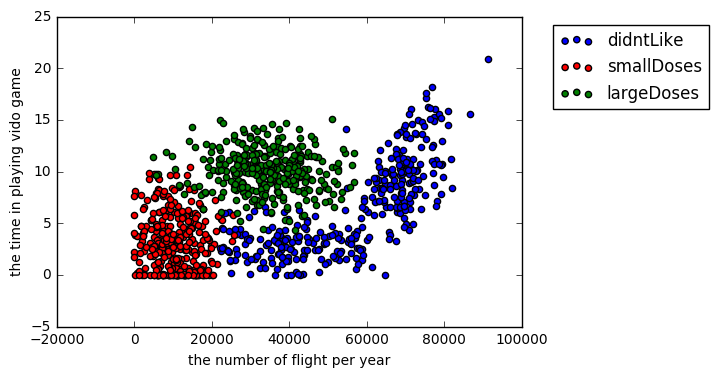

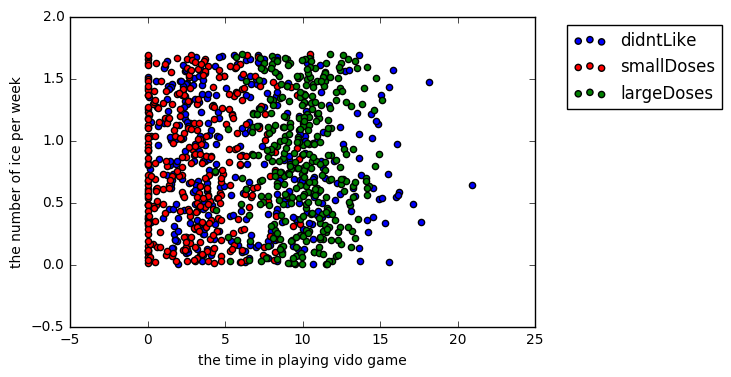

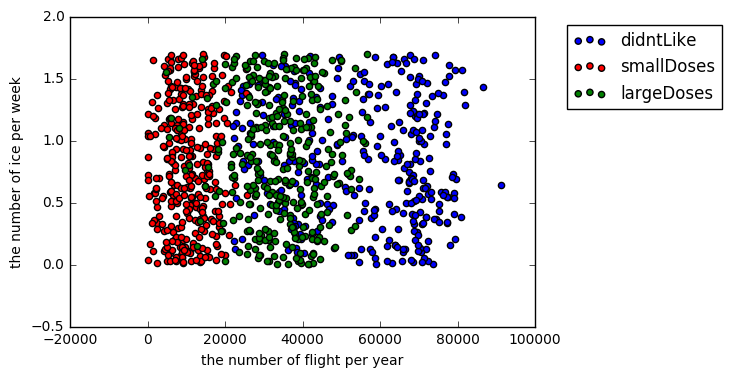

In [21]:
scatter2D(datingDataMat[:,0], datingDataMat[:,1], datingLabels, 'the number of flight per year', 'the time in playing vido game')
scatter2D(datingDataMat[:,1], datingDataMat[:,2], datingLabels, 'the time in playing vido game', 'the number of ice per week')
scatter2D(datingDataMat[:,0], datingDataMat[:,2], datingLabels, 'the number of flight per year', 'the number of ice per week')

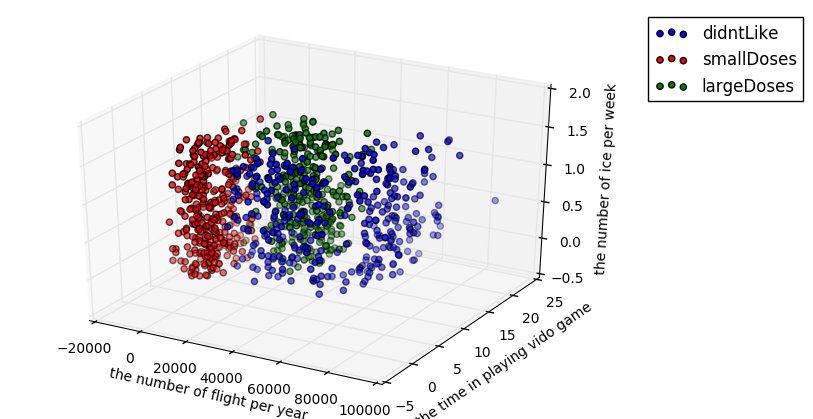

In [22]:
scatter3D(datingDataMat[:,0], datingDataMat[:,1], datingDataMat[:,2], datingLabels,
          'the number of flight per year', 
          'the time in playing vido game', 
          'the number of ice per week')

### normalization

In [23]:
def autoNorm(dataSet):
    minVals = dataSet.min(axis = 0) # min by column
    maxVals = dataSet.max(axis = 0)
    ranges = maxVals - minVals
    norDataSet = np.zeros(dataSet.shape)
    rows = dataSet.shape[0]
    norDataSet = dataSet - np.tile(minVals, (rows, 1))
    norDataSet = norDataSet / np.tile(ranges, (rows, 1))
    return norDataSet, ranges, minVals

In [24]:
datingDataNorMat, ranges , minVals = autoNorm(datingDataMat)
print(datingDataNorMat[:10,:])
print(ranges)
print(minVals)

[[ 0.44832535  0.39805139  0.56233353]
 [ 0.15873259  0.34195467  0.98724416]
 [ 0.28542943  0.06892523  0.47449629]
 [ 0.82320073  0.62848007  0.25248929]
 [ 0.42010233  0.07982027  0.0785783 ]
 [ 0.79972171  0.48480189  0.60896055]
 [ 0.39385141  0.32652986  0.71533516]
 [ 0.46745478  0.63464542  0.32031191]
 [ 0.73950675  0.41261212  0.44153637]
 [ 0.38875681  0.58668982  0.88936006]]
[  9.12730000e+04   2.09193490e+01   1.69436100e+00]
[ 0.        0.        0.001156]


### model test

In [25]:
def datingClassTest(k = 5, testRatio = 0.1, display = False):
    datingDataMat, datingLabels = file2matrix(DATA_ROOT+'datingDataSet/datingTestSet.txt', numOfFeatures=3)
    datingDataNorMat, _, _ = autoNorm(datingDataMat)
    rowsAll = datingDataNorMat.shape[0]
    rowsTest = int(testRatio*rowsAll)
    count = 0.0
    for i in range(rowsTest):
        preLabel = classify(datingDataNorMat[i,:], datingDataNorMat[rowsTest:rowsAll,:], 
                            datingLabels[rowsTest:rowsAll], k)
        if(display == True):
            print("predictive label: %d,  real label: %d" % (preLabel, datingLabels[i]))
        if(preLabel != datingLabels[i]):
            count += 1.0
    print("********** the total error rate is : %f  **************" % (count / rowsTest))

In [26]:
for k in range(2, 10):
    print("k = %d : \n" % (k))
    datingClassTest(k)

k = 2 : 

********** the total error rate is : 0.050000  **************
k = 3 : 

********** the total error rate is : 0.050000  **************
k = 4 : 

********** the total error rate is : 0.030000  **************
k = 5 : 

********** the total error rate is : 0.040000  **************
k = 6 : 

********** the total error rate is : 0.060000  **************
k = 7 : 

********** the total error rate is : 0.040000  **************
k = 8 : 

********** the total error rate is : 0.050000  **************
k = 9 : 

********** the total error rate is : 0.050000  **************


In [27]:
for ratio in np.arange(0.1, 1, 0.1):
    print("ratio = %f : \n" % (ratio))
    datingClassTest(k = 4, testRatio = ratio)

ratio = 0.100000 : 

********** the total error rate is : 0.030000  **************
ratio = 0.200000 : 

********** the total error rate is : 0.065000  **************
ratio = 0.300000 : 

********** the total error rate is : 0.066667  **************
ratio = 0.400000 : 

********** the total error rate is : 0.067500  **************
ratio = 0.500000 : 

********** the total error rate is : 0.062000  **************
ratio = 0.600000 : 

********** the total error rate is : 0.061667  **************
ratio = 0.700000 : 

********** the total error rate is : 0.060000  **************
ratio = 0.800000 : 

********** the total error rate is : 0.056250  **************
ratio = 0.900000 : 

********** the total error rate is : 0.081111  **************


## 2. Digit recognition 

dataset:  
- the number of class : 0 ~ 9 (number)
- feature : 32 * 32 image

### prepare data

In [28]:
def img2vector(filename):
    pixel = 32
    fr = open(filename)
    retVector = np.zeros((1, pixel*pixel))
    for i in range(pixel):
        lineStr = fr.readline()
        for j in range(pixel):
            retVector[0, i*pixel + j] = int(lineStr[j])
    return retVector

In [29]:
testVector = img2vector(DATA_ROOT+'digitsDataSet/testDigits/0_13.txt') 
testVector[0,0:31]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.])

### test algorithm

In [30]:
from os import listdir

def handwritingClassTest():
    imgSize = 32 * 32
    k = 3
    isPrint = True
    
    trainingFileList = listdir(DATA_ROOT+'digitsDataSet/trainingDigits/')
    rows = len(trainingFileList)
    trainingMat = np.zeros( (rows, imgSize) )
    hwLabels = np.zeros(rows, dtype=int)
    for i in range(rows):
        fileNameStr = trainingFileList[i]
        fileStr = fileNameStr.split('.')[0]
        labelStr = fileStr.split('_')[0]
        hwLabels[i] = int(labelStr)
        trainingMat[i,:] = img2vector(DATA_ROOT+'digitsDataSet/trainingDigits/{}'.format(fileNameStr))
    
    testFileList = listdir(DATA_ROOT+'digitsDataSet/testDigits/')
    rowsTest = len(testFileList)
    errorCount = 0.0
    for i in range(rowsTest):
        fileNameStr = testFileList[i]
        fileStr = fileNameStr.split('.')[0]
        realLabel = int(fileStr.split('_')[0])
        testVector = img2vector(DATA_ROOT+'digitsDataSet/testDigits/{}'.format(fileNameStr))
        preLabel = classify(testVector, trainingMat, hwLabels, k)
        if(isPrint):
            print("predictive label: %d, real label: %d\n" % (preLabel, realLabel))
        if(preLabel != realLabel):
            errorCount += 1.0
    
    print("the number of error: %d, the ratio of error: %f" % (errorCount, errorCount/rowsTest))

In [31]:
handwritingClassTest()

predictive label: 0, real label: 0

predictive label: 0, real label: 0

predictive label: 0, real label: 0

predictive label: 0, real label: 0

predictive label: 0, real label: 0

predictive label: 0, real label: 0

predictive label: 0, real label: 0

predictive label: 0, real label: 0

predictive label: 0, real label: 0

predictive label: 0, real label: 0

predictive label: 0, real label: 0

predictive label: 0, real label: 0

predictive label: 0, real label: 0

predictive label: 0, real label: 0

predictive label: 0, real label: 0

predictive label: 0, real label: 0

predictive label: 0, real label: 0

predictive label: 0, real label: 0

predictive label: 0, real label: 0

predictive label: 0, real label: 0

predictive label: 0, real label: 0

predictive label: 0, real label: 0

predictive label: 0, real label: 0

predictive label: 0, real label: 0

predictive label: 0, real label: 0

predictive label: 0, real label: 0

predictive label: 0, real label: 0

predictive label: 0, real la